In [1]:
%matplotlib qt

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Find homography given 4 pairs of correspondences

In [2]:
def find_H(correspondences):
    P = []
    for ((x1,y1),(x2,y2)) in correspondences[:4]:
        rows = [[x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
                [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]]
        P.extend(rows)

    _, __, V = np.linalg.svd(np.array(P))
    H = V[-1, :] / V[-1,-1]
    return H.reshape((3,3))

### Launch an interactive session that registers correspondences from mouse clicks

In [3]:
def find_correspondences(img1, img2):
    points = []
    def onclick(event):
        global correspondonces
        # print('in event')
        ix, iy = np.round((event.xdata, event.ydata))
        points.append((int(ix), int(iy)))

        if len(points)>=8:
            fig.canvas.mpl_disconnect(cid)
            correspondonces = [(p1, p2) for p1, p2 in zip(points[0::2], points[1::2])]
    
    fig = plt.figure(figsize=(25,10))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title('First view')

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title('Second view')

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

### Reading images and getting correspondences

In [4]:
img1 = cv.cvtColor(cv.imread('data/1_1.png'), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread('data/1_2.png'), cv.COLOR_BGR2RGB)

# correspondonces = []
# find_correspondences(img1, img2)

### Saved correspondonces

In [5]:
# correspondonces = [((232, 151), (111, 143)),
#                     ((229, 83), (113, 77)),
#                     ((148, 157), (26, 147)),
#                     ((253, 85), (135, 81))]
correspondonces = [((227, 80), (112, 74)),
                    ((197, 159), (78, 150)),
                    ((251, 82), (134, 78)),
                    ((194, 134), (77, 125))]

### Find homography using opencv

In [6]:
# h_cv, _ = cv.findHomography(img1_points, img2_points)
# h_cv_inv = np.linalg.inv(h_cv)
# h_cv, h_cv_inv

### Find homography using function above

In [7]:
h = find_H(correspondonces)
h_inv = np.linalg.inv(h)

### Transform points to display actual points vs their transformed counterparts

In [8]:
img1_points = np.array([p1 for p1,_ in correspondonces])
img2_points = np.array([p2 for _,p2 in correspondonces])
img2_transformed = np.array([np.matmul(h, np.array([*p1, 1])[:, np.newaxis]) for p1,_ in correspondonces])
img2_transformed = np.array([(x/x[2])[:2] for x in img2_transformed]).squeeze()
img1_inverse_transformed = np.array([np.matmul(h_inv, np.array([*p2, 1])[:, np.newaxis]) for _,p2 in correspondonces])
img1_inverse_transformed = np.array([(x/x[2])[:2] for x in img1_inverse_transformed]).squeeze()

### Plotting points calculated above

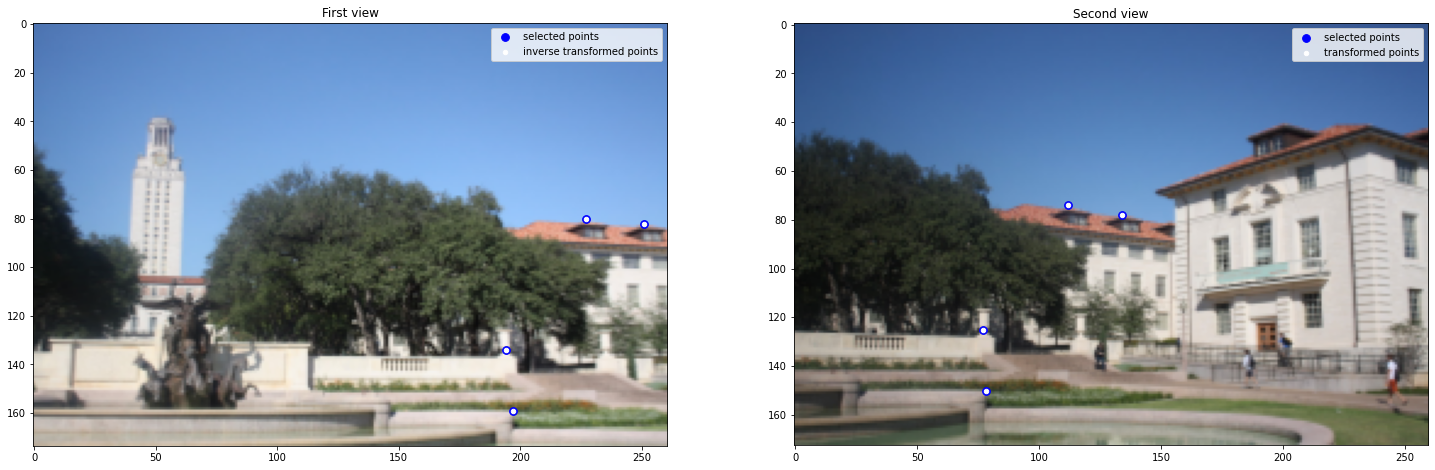

In [9]:
a = 1
s1 = 60
s2 = 20

fig = plt.figure(figsize=(25,10))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.scatter(img1_points[:,0], img1_points[:,1], c='blue', label='selected points', alpha=a, s=s1)
plt.scatter(img1_inverse_transformed[:,0], img1_inverse_transformed[:,1], c='white', label='inverse transformed points', alpha=a, s=s2)
plt.title('First view')
plt.legend()

plt.subplot(1,2,2)
plt.imshow(img2)
plt.scatter(img2_points[:,0], img2_points[:,1], c='blue', label='selected points', alpha=a, s=s1)
plt.scatter(img2_transformed[:,0], img2_transformed[:,1], c='white', label='transformed points', alpha=a, s=s2)
plt.title('Second view')
plt.legend()

plt.show()

### Functions used for warping

In [29]:
def get_boundary(img, H):
    # corner_points = [[0, 0, img.shape[0]-1, img.shape[0]-1], [0, img.shape[1]-1, 0, img.shape[1]-1]]
    corner_points = [(0,0), (img.shape[1]-1,0), (0, img.shape[0]-1), (img.shape[1]-1, img.shape[0]-1)]
    new_corners = [[], []]
    for x,y in corner_points:
        # y, x = corner_points[0][i], corner_points[1][i]
        point = np.array([x, y, 1])[:, np.newaxis]
        new_point = np.matmul(H, point).squeeze()
        xi, yi, _ = new_point/new_point[2]
        new_corners[0].append(xi)
        new_corners[1].append(yi)
    
    min_x, max_x = min(new_corners[0]), max(new_corners[0])
    min_y, max_y = min(new_corners[1]), max(new_corners[1])
    return (max_x, min_x), (max_y, min_y)

def get_nearest_points(point, weights=False):
    x,y = point
    points = [(int(np.floor(x)), int(np.floor(y))), (int(np.floor(x)), int(np.ceil(y))),
              (int(np.ceil(x)), int(np.floor(y))), (int(np.ceil(x)), int(np.ceil(y)))]
    if weights:
        weights = [(np.ceil(x)-x) * (np.ceil(y)-y), (np.ceil(x)-x) * (y-np.floor(y)),
              (x-np.floor(x)) * (np.ceil(y)-y), (x-np.floor(x)) * (y-np.floor(y))]
        return points, weights
    else:
        return points

def interpolate(img, point):
    intensity = 0
    points, weights = get_nearest_points(point, weights=True)
    for (x,y), weight in zip(points, weights):
        if x>=0 and x<img.shape[1] and y>=0 and y<img.shape[0]:
            intensity += img[y,x]*weight
    
    return intensity

def warp_singlechannel(img, H):
    global offset_x, offset_y, ob
    (max_x, min_x), (max_y, min_y) = get_boundary(img, H)
    w = int(np.ceil(max_x)-np.floor(min_x))
    h = int(np.ceil(max_y)-np.floor(min_y))
    output_shape = (h,w)
    # print(output_shape)

    if min_x<0:
        offset_x = (int(np.floor(min_x))*-1)-1
    else:
        offset_x = 0

    if min_y<0:
        offset_y = (int(np.floor(min_y))*-1)-1
    else:
        offset_y = 0
    # offset_x, offset_y = 0,0
    
    output = np.zeros(output_shape)
    splatted = {}
    ob = 0
    # Forward warp
    for y in range(img.shape[0]): # for each row
        for x in range(img.shape[1]): # for each column
            intensity = img[y,x]
            pose = np.array([x,y,1])[:, np.newaxis] # homogoenous coordinates
            new_pose = np.matmul(H, pose).squeeze() # find new coordinates
            new_pose = new_pose/new_pose[2] # normalize
            new_pose[0]+=offset_x
            new_pose[1]+=offset_y
            x_new, y_new = new_pose[:2]
            if (np.ceil(x_new)-x_new + np.ceil(y_new)-y_new)==0: # if resulting coordinates are whole numbers
                output[y_new,x_new] = intensity # update intensity
            else: # if not splatting is required
                points = set(get_nearest_points(new_pose[:2])) # get four nearest points
                for x_near,y_near in points: # for each point
                    if x_near<0 or x_near>=w or y_near<0 or y_near>=h:
                        continue
                    if (y_near,x_near) in splatted: # if point has been splatted before
                        n, avg_intensity = splatted[(y_near,x_near)] # get old number of splatting contributors
                        new_avg = (n*avg_intensity+intensity)/(n+1)
                        splatted[(y_near,x_near)] = (n+1, new_avg) # update by adding current intensity
                    else: # otherwise
                        splatted[(y_near,x_near)] = (1, intensity) # avg intensity is current intensity with only 1 contributor
    # Apply splatting
    for point in splatted.keys():
        _, avg_intensity = splatted[point]
        output[point] = int(avg_intensity)
    
    # Inverse warp
    # H_inv = np.linalg.inv(H) # calculate inverse homography
    # to_warp = [(x,y) for y, x in zip(*np.where(output==0))] # find points to warp. i.e. points that were not updated during forward warp
    # for x,y in to_warp: # for each point
    #     x, y = x-offset_x, y-offset_y
    #     new_pose = np.array([x,y,1])[:, np.newaxis] # homogenous coords
    #     pose = np.matmul(H_inv, new_pose).squeeze() # apply inverse warping
    #     pose = (pose/pose[2])
    #     interp = interpolate(img, pose[:2]) # interpolate to find intensity
    #     x, y = x+offset_x, y+offset_y
    #     output[y,x] = int(interp)

    return output

def merge(r,g,b):
    img = np.zeros(r.shape).tolist()
    for row in range(len(img)):
        for col in range(len(img[0])):
            img[row][col] = [r[row,col], g[row,col], b[row,col]]

    return np.array(img, dtype=np.int64)

def warp_multichannel(img, H):
    output_img = []
    for channel in cv.split(img):
        warped_channel = warp_singlechannel(channel, H)
        output_img.append(warped_channel)
        
    return cv.merge(output_img).astype(np.int64)
    # return merge(*output_img)

def warp(img, H):
    if len(img.shape)==3 and img.shape[0]>3:
        return warp_multichannel(img, H)
    else:
        return warp_singlechannel(img, H)

### Warp first view into second view using homography extracted before

In [30]:
img1_warped = warp_multichannel(img1, h)

### Plot warped first view vs second view

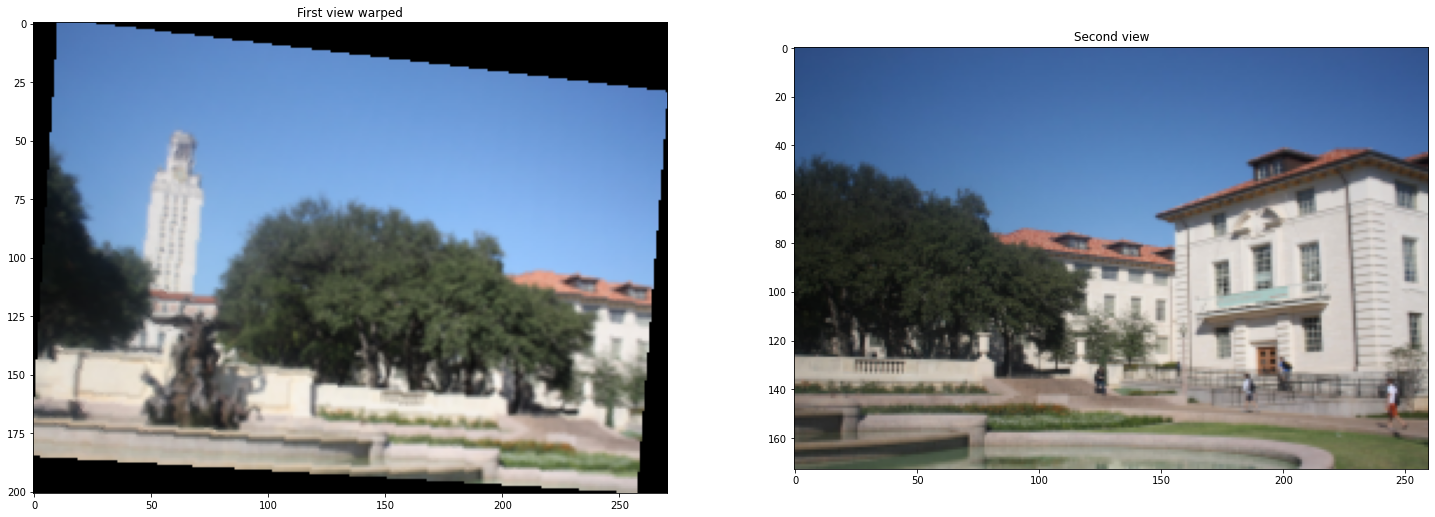

In [31]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.imshow(img1_warped)
plt.title('First view warped')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Second view')

plt.show()

### Create an image large enough to hold both views

In [32]:
img1_warped_adjusted = np.zeros((img2.shape[0]+offset_y, img2.shape[1]+offset_x, 3), dtype=np.int64)
img2_t = np.zeros((img2.shape[0]+offset_y, img2.shape[1]+offset_x, 3), dtype=np.int64)
for x in range(img2.shape[0]):
    for y in range(img2.shape[1]):
        img2_t[x+offset_y, y+offset_x] = img2[x,y]

for x in range(img1_warped.shape[0]):
    for y in range(img1_warped.shape[1]):
        img1_warped_adjusted[x, y] = img1_warped[x,y]


### Overlay function that overlays 2 images taking the avg intensities in areas of overlap

In [33]:
def overlay(img1, img2):
    op = np.zeros(img2.shape, dtype=np.int64)
    for i in range(op.shape[0]):
        for j in range(op.shape[1]):
            if np.all(img1[i,j]==0):
                op[i,j] = img2[i,j]
            elif np.all(img2[i,j]==0):
                op[i,j] = img1[i,j]
            else:
                op[i,j] = (img1[i,j]+img2[i,j])/2
    return op

### Overlaying warped view with second view

In [34]:
# mosaic = cv.addWeighted(img1_warped_adjusted, 1, img2_t, 1, 0)
mosaic = overlay(img1_warped_adjusted, img2_t)

### Plotting output

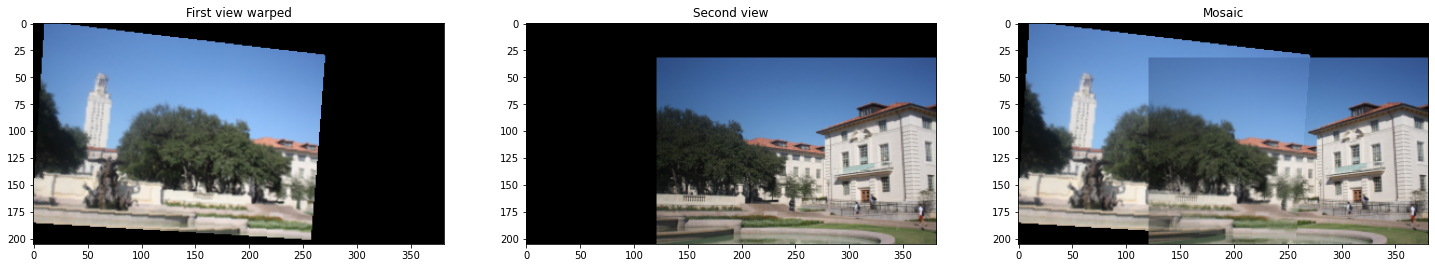

In [36]:
fig = plt.figure(figsize=(25,10))

plt.subplot(1, 3, 1)
plt.imshow(img1_warped_adjusted)
plt.title('First view warped')

plt.subplot(1,3,2)
plt.imshow(img2_t)
plt.title('Second view')

plt.subplot(1,3,3)
plt.imshow(mosaic)
plt.title('Mosaic')

plt.show()